In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla V100-SXM2-32GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [2]:
batch_size = 16   # Mini-batch size
num_epochs = 40
learning_rate = 0.0001

In [3]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
%matplotlib inline

dataset_path  = '../input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

## 데이터 전처리 함수 정의 (Dataset)

In [5]:
with open("sdf.pickle","rb") as sdf:
        sorted_df = pickle.load(sdf)
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [6]:
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2
#https://gist.github.com/ernestum/601cdf56d2b424757de5 elastic transform

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [7]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,192,0,128
2,Paper,0,128,192
3,Paper pack,0,128,64
4,Metal,128,0,0
5,Glass,64,0,128
6,Plastic,64,0,192
7,Styrofoam,192,128,64
8,Plastic bag,192,192,128
9,Battery,64,64,128


In [8]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

image shape: [3, 512, 512]


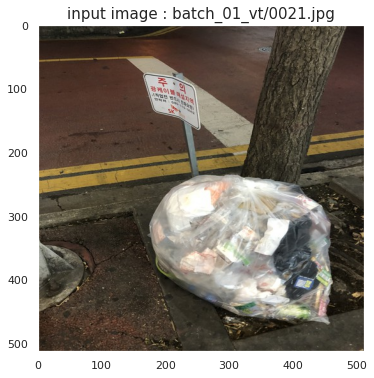

In [9]:
# test_loader의 output 결과(image) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

In [10]:
import segmentation_models_pytorch as smp

In [11]:
model = smp.UnetPlusPlus(
            encoder_name="timm-efficientnet-b8",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",
            in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=11,  # model output channels (number of classes in your dataset)
)

## 모델 저장 함수 정의

In [12]:
# 모델 저장 함수 정의
val_every = 1

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)

def save_model(model, saved_dir, file_name='unetpp(pretrained2).pt56'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model, output_path)

## 모델 생성 및 Loss function, Optimizer 정의

## 저장된 model 불러오기 (학습된 이후) 

In [33]:
# best model 저장된 경로
model_path = './saved/unetpp(pretrained2).pt20'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

model = model.to(device)
# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
model.eval()

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): Swish()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
          (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): Swish()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(72, 18, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(18, 72, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(72, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [14]:
with open('unetpp.pickle', 'wb') as f:
    pickle.dump(model, f)

In [15]:
model

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): Swish()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
          (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): Swish()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(72, 18, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(18, 72, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(72, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats

### `plot_examples()` 시각화 함수 정의

In [16]:
def plot_examples(mode="test", batch_id=0, num_examples=batch_size, dataloaer=test_loader):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size(e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    result = None
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    # test / validation set에 대한 시각화
    if (mode == 'test'):
        with torch.no_grad():
            for index, (imgs, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs

                    model.eval()
                    
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    result = outs
                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 4*num_examples), constrained_layout=True)

        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][1].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][1].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    return result

#### test set 시각화

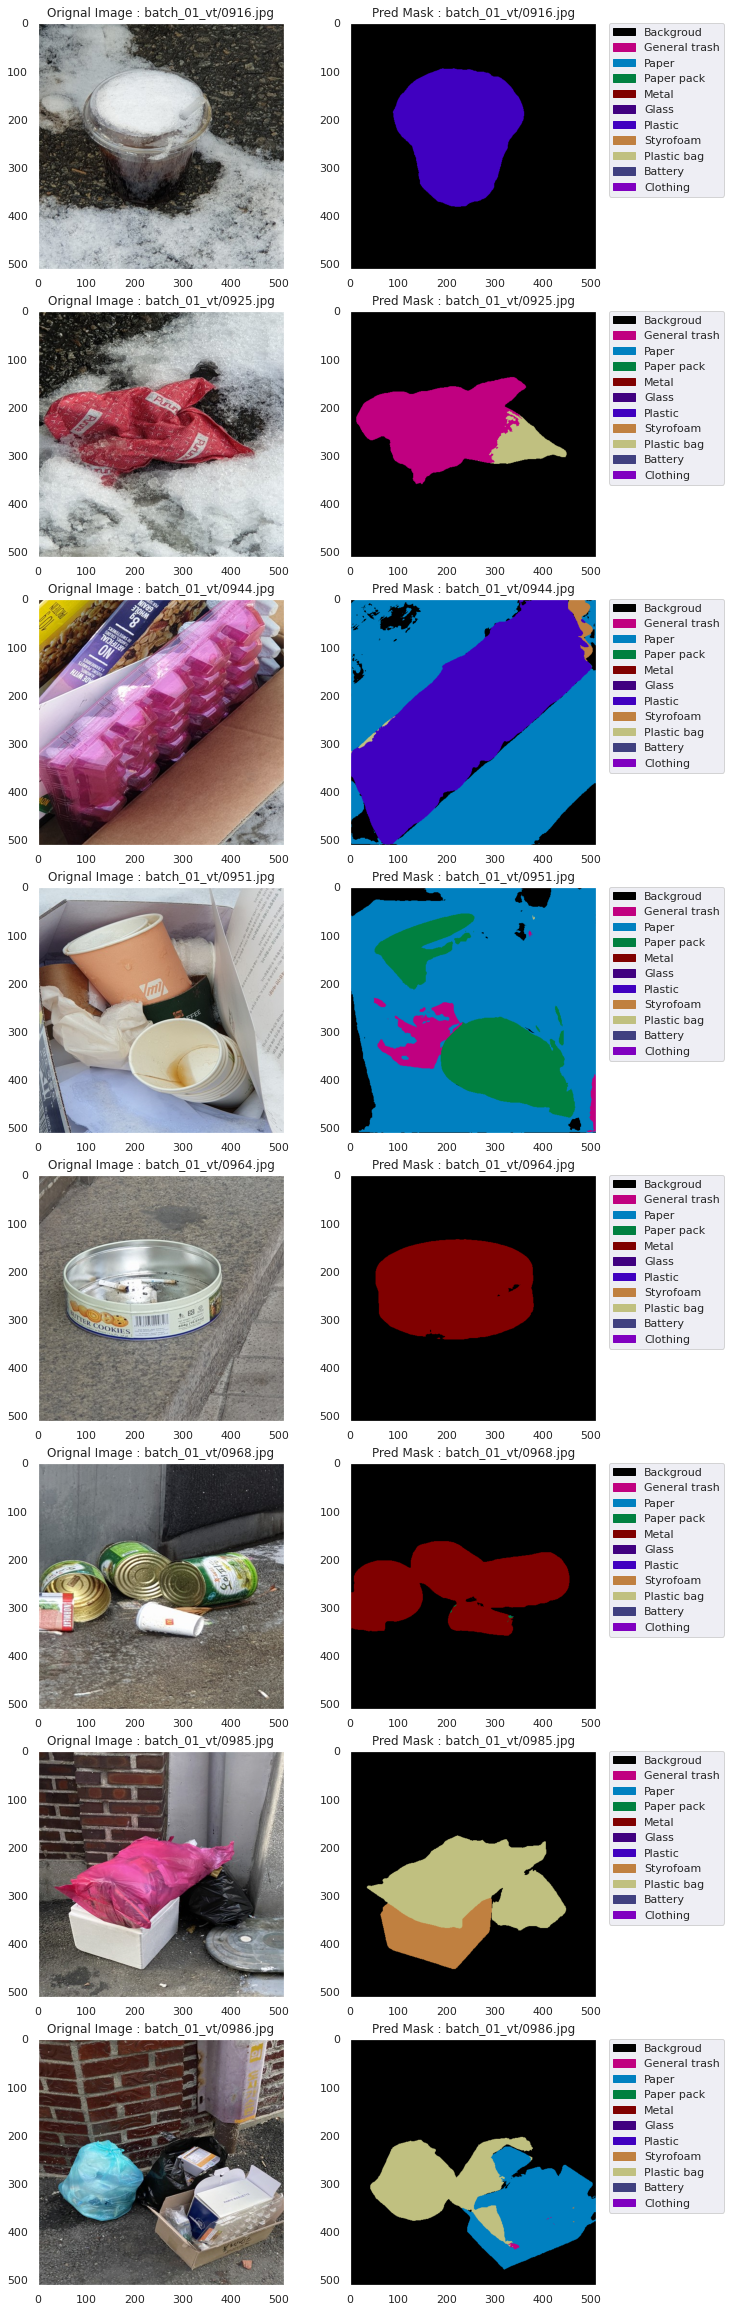

In [34]:
temp = plot_examples(mode="test", batch_id=5, num_examples=8, dataloaer=test_loader)

In [18]:
temp[0][8]

tensor([[-1.7926, -3.3612, -3.4717,  ..., -3.3738, -3.0757, -2.2549],
        [-2.9187, -4.9920, -5.2999,  ..., -5.2331, -4.7994, -3.6616],
        [-3.2863, -5.1093, -5.3606,  ..., -5.7219, -5.6512, -3.9727],
        ...,
        [-3.8040, -5.6599, -5.6702,  ..., -4.4414, -4.3641, -3.4887],
        [-3.3016, -4.9550, -5.0615,  ..., -4.3294, -3.7574, -3.0352],
        [-2.0045, -2.6843, -2.8355,  ..., -2.5662, -2.0304, -1.1341]],
       device='cuda:0')

In [19]:
import ttach as tta

In [20]:
tt_transform = tta.Compose([tta.HorizontalFlip(),tta.Rotate90([0,90])])
tt_model = tta.SegmentationTTAWrapper(model,tt_transform,merge_mode='mean')
tt_model.eval()

SegmentationTTAWrapper(
  (model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
            (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(72, 18, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(18, 72, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(72, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): Ba

## submission을 위한 test 함수 정의

In [21]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(size, size)])
    print('Start prediction.')
    
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
            
            # inference (512 x 512)
            outs = tt_model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)
                
            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [22]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/unnet(pretrained20epoch).csv", index=False)

  0%|          | 0/52 [00:00<?, ?it/s]

Start prediction.


KeyboardInterrupt: 